# Following Along YouTube Tutorial

In [15]:
# Import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore')

In [16]:
# Load our Data.

df = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col=['Month'])

In [17]:
# Check it out.

df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


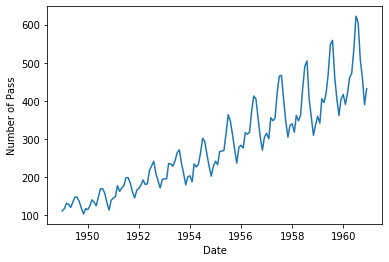

In [18]:
# Plot and see what our data looks like.

plt.xlabel('Date')
plt.ylabel('Number of Pass')
plt.plot(df)

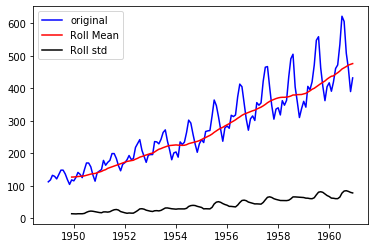

In [19]:
# Let us start to check that the Time Series is Stationary. 

rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()

# Plot

plt.plot(df, color = 'blue', label = 'original')
plt.plot(rolling_mean, color = 'red', label = 'Roll Mean')
plt.plot(rolling_std, color = 'black', label = 'Roll std')
plt.legend(loc = 'best')
plt.show()

### Graphically we can see that it is not stationary.

In [20]:
# Now we use The adF test.

result = adfuller(df['#Passengers'])

print('ADF Stat: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('critial values')
for key, value in result[4].items():
    print('\t{}: {}'.format(key,value))

ADF Stat: 0.8153688792060569
p-value: 0.9918802434376411
critial values
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


### Comparing above we can see by stats that it is not stationary.

In [23]:
# Create a Function that can tell us how stationary the time series data is. 

def get_stationary(timeseries):
    
    rolling_mean = timeseries.rolling(window = 12).mean()
    rolling_std = timeseries.rolling(window = 12).std()
    
    # Plot
    
    OG = plt.plot(timeseries, color = 'blue', label = 'original')
    mean = plt.plot(rolling_mean, color = 'red', label = 'Roll Mean')
    dtd = plt.plot(rolling_std, color = 'black', label = 'Roll std')
    plt.legend(loc = 'best')
    plt.show()
    
    # Now we use The adF test.
    result = adfuller(timeseries['#Passengers'])

    print('ADF Stat: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('critial values')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key,value))

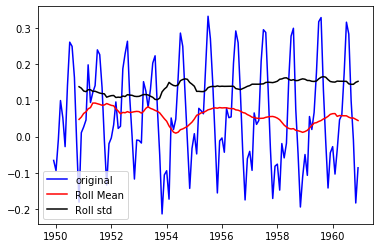

ADF Stat: -3.162907991300853
p-value: 0.022234630001244135
critial values
	1%: -3.4865346059036564
	5%: -2.8861509858476264
	10%: -2.579896092790057


In [24]:
# First way of trying to get rid of the non-stionaryness of the data. 

df_log = np.log(df)
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)

get_stationary(df_log_minus_mean)

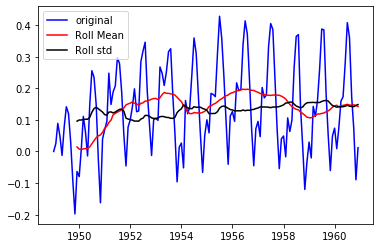

ADF Stat: -3.601262420161668
p-value: 0.0057369388015120655
critial values
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


In [25]:
# Testing it out with exp decay.

rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace = True)

get_stationary(df_log_exp_decay)

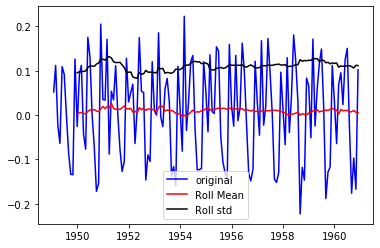

ADF Stat: -2.7171305983881346
p-value: 0.07112054815085846
critial values
	1%: -3.4825006939887997
	5%: -2.884397984161377
	10%: -2.578960197753906


In [26]:
# Here we use shifting to try to get the time series to be stationary.

df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace = True)

get_stationary(df_log_shift)

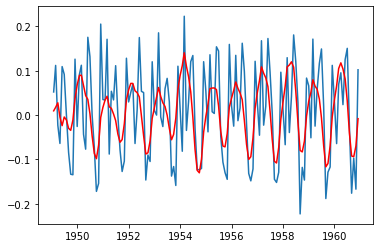

In [27]:
# Creating our ARIMA Model.

decomposition = seasonal_decompose(df_log)

model = ARIMA(df_log, order = (2,1,2))
results = model.fit(disp =-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color = 'red')

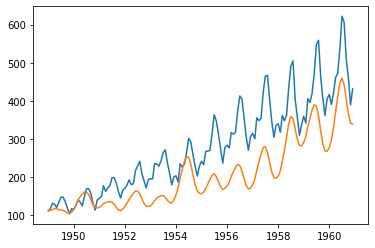

In [29]:
# Now we plot the model after making it non-stationary.

pred_Arima_diff = pd.Series(results.fittedvalues, copy = True)
pred_Arima_diff_cumsum = pred_Arima_diff.cumsum()
pred_Arima_log = pd.Series(df_log['#Passengers'].iloc[0], index = df_log.index )
pred_Arima_log = pred_Arima_log.add(pred_Arima_diff_cumsum, fill_value = 0)
pred_Arima = np.exp(pred_Arima_log)
plt.plot(df)
plt.plot(pred_Arima)